In [188]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import _pickle as pickle
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import texcrapy
#from konlpy.corpus import word
from ckonlpy.tag import Twitter, Postprocessor
import json
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer, LTokenizer
from soynlp.noun import LRNounExtractor_v2
from soynlp.pos.tagset import tagset
from soynlp.postagger import Dictionary as Dict
from soynlp.postagger import LRTemplateMatcher
from soynlp.postagger import LREvaluator
from soynlp.postagger import SimpleTagger
from soynlp.postagger import UnknowLRPostprocessor

import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
from nltk.tag import untag
import math
import os
import re

# from threading import Thread
#from multiprocessing import Process
# import dask
# from dask import compute, delayed
# import dask.multiprocessing
# import dask.bag as db
# import jpype
from sklearn import preprocessing

import gensim
from gensim.models import Word2Vec, Doc2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models.doc2vec import TaggedDocument

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Scraping

In [175]:
df = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','kw_supporter','kw_supported','keywords']]; df
_or = lambda kw: ' OR '.join(['#' + k.strip() for k in kw.split(',')])

qry_base = {row.shortname:_or(row.keywords) for row in df.itertuples()}
supporters = df.shortname[df.kw_supporter==True]
qry_sup = ' OR '.join([qry_base[sup] for sup in supporters]); qry_sup
qry = {row.shortname: '(' + qry_base[row.shortname] + ') AND (' + qry_sup + ')' if row.kw_supported==True else qry_base[row.shortname] for row in df.itertuples()}

In [ ]:
%%time
what = ['id', 'timestamp', 'text']
texcrapy.scrap(qry, what=what, lang='ko', end='2019-01-31', download_to='scrapped/twitter')

# Making Corpus

In [4]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()
    

class JsonCorpus:
    def __init__(self, *fnames, textkey='text'):
        self.fnames = fnames
        self.textkey = textkey
        self.corpus = self._corpus()
    
    def _corpus(self):
        corpus = {}
        nfiles = len(self.fnames)
        
        for i, fname in enumerate(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f:                
                for item, docs in json.load(f).items():
                    corpus[item] = [preproc(doc[self.textkey]) for doc in docs]
                
                pct = '%.2f' % (100 * (i+1) / nfiles)
                print('\r {pct}% completed'.format(pct=pct), end='')
        
        print('\n')
        return corpus
    
                
    def __iter__(self):
        for sents in self.corpus.values():
            yield from sents

    def __len__(self):
        return sum([len(sents) for sents in self.corpus.values()])
    
    def tokenize(self, tagger):
        return DocTokens(tagger, **self.corpus)


    
class DocTokens:
    def __init__(self, tagger, **corpora):
        self.tagger = tagger
        self.tokensdict = self._get_tokens(**corpora)
    
        
    def _get_tokens(self, **corpora):
        tokens = {}
        for item, corpus in tqdm_notebook(list(corpora.items())[:]):
            tokens[item] = [[w[0] for w in self.tagger.tag(corp) if w[1] is not None] for corp in set(corpus)]
        return tokens
                    
    def __iter__(self):
        for item, toks in self.tokensdict.items():
            for _toks in toks:
                yield TaggedDocument(words=_toks, tags=[item])
            
    def __len__(self):
        return sum([len(toks) for toks in self.tokensdict.values()])

In [5]:
%%time
fnames = ['scrapped/twitter/' + fname for fname in os.listdir('scrapped/twitter')]
jcorpus = JsonCorpus(*fnames)

 100.00% completed

Wall time: 28.5 s


In [6]:
jcorpus.corpus['coteciel']

['140815 nayeon instagram update 집념의 한국인 구했다 잘메고다녀주마 꼬떼씨엘 coteetciel 백팩 coteetcielofficial',
 '140815 nayeon instagram update 집념의 한국인 구했다 잘메고다녀주마 꼬떼씨엘 coteetciel 백팩 coteetcielofficial',
 'nayeonstagram 집념의 한국인 구했다 잘메고다녀주마 꼬떼씨엘 coteetciel 백팩 coteetcielofficial',
 'nayeonstagram 집념의 한국인 구했다 잘메고다녀주마 꼬떼씨엘 coteetciel 백팩',
 '상위태그 3시간 1 도화선 2 친일파 3 패스트코 4 럭셔리 5 럭셔리그램 6 백스타그램 7 꼬떼씨엘 8 luxerystyle 9 애플 10 인용 11 어린이날',
 '상위태그 3시간 1 도화선 2 친일파 3 패스트코 4 럭셔리 5 quote 6 럭셔리그램 7 백스타그램 8 꼬떼씨엘 9 luxerystyle 10 지방재정개혁',
 '상위태그 3시간 1 도화선 2 친일파 3 luxerystyle 4 백스타그램 5 럭셔리 6 패스트코 7 애플 8 꼬떼씨엘 9 럭셔리그램 10 어린이날',
 'repost 패스트코 훼이스북에서 가져왔어요 꼬떼씨엘 애플 백스타그램 럭셔리 럭셔리_익스피리언스 럭셔리그램 luxerystyle',
 '패스트코 훼이스북에서 가져왔어요 꼬떼씨엘 애플 백스타그램 럭셔리 럭셔리_익스피리언스 럭셔리그램 luxerystyle']

# Making Dictionary

### 1. From Scraping keywords

In [7]:
df_keywords = pd.read_excel('keywords and logos.xlsx', sheet_name='20190304')['keywords']
keywords = {w.strip() for w in ', '.join(df_keywords).split(',')}

### 2. Soynlp nouns

In [8]:
noun_extractor = LRNounExtractor_v2(verbose=True)
_soynouns = noun_extractor.train_extract(jcorpus, min_noun_score=0.3, min_noun_frequency=5)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 493329 from 429969 sents. mem=0.338 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=6680411, mem=1.450 Gb
[Noun Extractor] batch prediction was completed for 112092 words
[Noun Extractor] checked compounds. discovered 106245 compounds
[Noun Extractor] postprocessing detaching_features : 23448 -> 23277
[Noun Extractor] postprocessing ignore_features : 23277 -> 23178
[Noun Extractor] postprocessing ignore_NJ : 23178 -> 22851
[Noun Extractor] 22851 nouns (106245 compounds) with min frequency=5
[Noun Extractor] flushing was done. mem=1.689 Gb                    
[Noun Extractor] 75.02 % eojeols are covered


In [9]:
soynouns = _soynouns.keys()
soyngrams = {v for k,v in noun_extractor._compounds_components.items() if k in soynouns}

In [10]:
word_extractor = WordExtractor()
word_extractor.train(jcorpus)
_soywords = word_extractor.extract()

training was done. used memory 2.529 Gbse memory 2.683 Gb
all cohesion probabilities was computed. # words = 264323
all branching entropies was computed # words = 446112
all accessor variety was computed # words = 446112


In [11]:
def word_score(score):
    return score.cohesion_forward * math.exp(score.right_branching_entropy)

soywords = {word for word, score in _soywords.items() if word_score(score)>0.1}

### 3. Korean words

In [12]:
with open('dic_system.txt', encoding='UTF-8-sig') as f:
    lines = f.readlines()
    
kowords = {tok.split('\t')[0] for tok in lines}

### 4. English words

In [13]:
enwords = set(WORDS.words())

### 5. Custom words

In [14]:
cwords = '''
'''

cwords = set(re.findall(r'[^ ,]+', re.sub(r'\n', '', cwords)))

In [15]:
pos_dict = {
    'Adverb': {}, 
    'Noun': keywords | soynouns | soywords | kowords | enwords | cwords, 
    'Josa': {},
    'Verb': {},
    'Adjective': {},
    'Exclamation': {},
}

dictionary = Dict(pos_dict)
generator = LRTemplateMatcher(dictionary)    
evaluator = LREvaluator()
postprocessor = UnknowLRPostprocessor()
tagger = SimpleTagger(generator, evaluator, postprocessor)

In [16]:
tagger.tag(jcorpus.corpus['coteciel'][1]);

In [17]:
%%time
tokens = jcorpus.tokenize(tagger)


Wall time: 3min 15s


In [19]:
tokens.tokensdict['crocs'];

# Tagger 객체 저장

In [20]:
with open('model/tagger.pickle', 'wb') as f:
    pickle.dump(tagger, f)

In [21]:
with open('model/tagger.pickle', 'rb') as f:
    tagger = pickle.load(f)

# Doc2vec

In [26]:
d2v = Doc2Vec(tokens, vector_size=100, window=5, min_count=10, workers=4)
d2v.save('model/doc2vec.model')

In [61]:
d2v.init_sims(replace=True)

In [27]:
d2v = Word2Vec.load('model/doc2vec.model')

In [28]:
d2v.docvecs.most_similar(positive=['nike'], negative=['adidas'])

[('supreme', 0.2928835153579712),
 ('acronym', 0.23972950875759125),
 ('underarmour', 0.21875041723251343),
 ('woolrich', 0.21489018201828003),
 ('8seconds', 0.20763862133026123),
 ('gyakusou', 0.20322123169898987),
 ('beanpole', 0.19406844675540924),
 ('poloralphlauren', 0.18710462749004364),
 ('saintlaurent', 0.18576635420322418),
 ('wilson', 0.18348200619220734)]

1

In [29]:
def _simwords(what, n):
    toks = [w[0] for w in tagger.tag(what)]
    _toks = [w for w in toks if w in d2v.wv.vocab]
    sw = [w[0] for w in d2v.wv.most_similar(positive=_toks, topn=n)] + toks
    return set(sw)

def _diffwords(what, n):
    toks = [w[0] for w in tagger.tag(what)]
    _toks = [w for w in toks if w in d2v.wv.vocab]
    sw = [w[0] for w in d2v.wv.most_similar(negative=_toks, topn=n)]
    return set(sw)

def _simwords_vec(what, n):
    return [d2v.wv[w] for w in _simwords(what, n) if w in d2v.wv.vocab]

def _diffwords_vec(what, n):
    return [d2v.wv[w] for w in _diffwords(what, n) if w in d2v.wv.vocab]

In [37]:
# _simwords(searchkey, 30);

In [38]:
# _simwords_vec(searchkey, 30);

In [62]:
# %%time
searchkey = '럭셔리 가방'
poskey = [d2v.infer_vector(_simwords(searchkey, 30), epochs=300)]#, alpha=0.25)]
d2v.docvecs.most_similar(positive=poskey, topn=300)

[('pleasuresclothing', 0.7508863210678101),
 ('coteciel', 0.7473301887512207),
 ('ferragamo', 0.7331358790397644),
 ('isseymiyake', 0.7208532094955444),
 ('rimowa', 0.7200955152511597),
 ('yojiyamamoto', 0.7175536155700684),
 ('tods', 0.7160711884498596),
 ('marceloburlon', 0.7035541534423828),
 ('pearlygates', 0.7034860253334045),
 ('bottegaveneta', 0.7006471157073975),
 ('samsonite', 0.6998499631881714),
 ('tartoptical', 0.6985296010971069),
 ('pleatsplease', 0.6958053708076477),
 ('urutokyo', 0.6938735842704773),
 ('montblanc', 0.6923403143882751),
 ('sandro', 0.6920188665390015),
 ('thursdayisland', 0.6917072534561157),
 ('jlindeberg', 0.6908303499221802),
 ('rokit', 0.6900686025619507),
 ('n21', 0.6888042688369751),
 ('gstarraw', 0.6863358020782471),
 ('system', 0.6860406994819641),
 ('girlsdontcry', 0.6857556104660034),
 ('maje', 0.6854478120803833),
 ('toryburch', 0.6843999624252319),
 ('noah', 0.6832315921783447),
 ('cutlerandgross', 0.6825813055038452),
 ('tumi', 0.68204665184

In [60]:
# 요게 제일 나은듯

# %%time
searchkey = '해변 샌들'
poskey = _simwords_vec(searchkey, 30)
d2v.docvecs.most_similar(positive=poskey, topn=20)

[('teva', 0.8243236541748047),
 ('birkenstock', 0.7982650399208069),
 ('ugg', 0.795760989189148),
 ('cos', 0.7843093872070312),
 ('theory', 0.7786827087402344),
 ('time', 0.7767782211303711),
 ('suicoke', 0.7717025279998779),
 ('pleatsplease', 0.7712861895561218),
 ('topten', 0.7712770700454712),
 ('apc', 0.7702951431274414),
 ('eastpak', 0.7649796009063721),
 ('bershka', 0.7647624015808105),
 ('awakeny', 0.7640367746353149),
 ('veja', 0.7616139054298401),
 ('cherryla', 0.7603119611740112),
 ('soup', 0.7568873763084412),
 ('discovery', 0.7563183307647705),
 ('topshop', 0.753461480140686),
 ('plasticisland', 0.7527220249176025),
 ('amiri', 0.752384603023529)]

In [54]:
%%time
d2v.docvecs.most_similar(positive=[d2v.wv['럭셔리']], topn=20)

Wall time: 9 ms


[('montblanc', 0.6617202758789062),
 ('sacai', 0.6157494783401489),
 ('ermenegildozegna', 0.6094779968261719),
 ('hermes', 0.609326183795929),
 ('nationalgeography', 0.601405143737793),
 ('balmain', 0.599767804145813),
 ('vivianwestwood', 0.5972344875335693),
 ('clubmonaco', 0.5735753774642944),
 ('tods', 0.5730624198913574),
 ('coteciel', 0.5692532062530518),
 ('yojiyamamoto', 0.5672576427459717),
 ('bottegaveneta', 0.5626093149185181),
 ('hugoboss', 0.552722156047821),
 ('maxmara', 0.5466232299804688),
 ('prada', 0.5454100370407104),
 ('moscot', 0.5445988178253174),
 ('pearlygates', 0.5401676297187805),
 ('dolcegabbana', 0.5382061004638672),
 ('bally', 0.538009524345398),
 ('monclear', 0.5378274321556091)]

In [55]:
d2v.docvecs.most_similar(positive=_simwords_vec(searchkey,30), negative=_diffwords_vec(searchkey,30), topn=300)

[('isseymiyake', 0.7528330087661743),
 ('bottegaveneta', 0.7475889921188354),
 ('coteciel', 0.7206209301948547),
 ('toryburch', 0.7173346281051636),
 ('ferragamo', 0.7162785530090332),
 ('vivianwestwood', 0.7113078832626343),
 ('plasticisland', 0.705762505531311),
 ('pearlygates', 0.6973544359207153),
 ('moscot', 0.693939208984375),
 ('paulsmith', 0.6909399628639221),
 ('rimowa', 0.6867916584014893),
 ('tods', 0.685397744178772),
 ('time', 0.6836609840393066),
 ('ermenegildozegna', 0.6833614110946655),
 ('charleskeith', 0.6809303760528564),
 ('pleasuresclothing', 0.6787161827087402),
 ('pleatsplease', 0.6782567501068115),
 ('coach', 0.6744545698165894),
 ('balenciaga', 0.6695948839187622),
 ('tumi', 0.6627806425094604),
 ('cherryla', 0.6617143750190735),
 ('maisonmargiela', 0.659013032913208),
 ('celine', 0.6581742763519287),
 ('alexandermcqueen', 0.6580557823181152),
 ('montblanc', 0.6545995473861694),
 ('system', 0.653503954410553),
 ('yojiyamamoto', 0.6517916917800903),
 ('versace',

# 유사 브랜드 찾기

In [147]:
d2v.wv.most_similar(positive=[d2v.docvecs['nike']])

[('에어', 0.7411279082298279),
 ('조던', 0.7409265041351318),
 ('ld1000', 0.7324894666671753),
 ('footballer', 0.7302910089492798),
 ('갸쿠소우', 0.7284371852874756),
 ('gyakusou', 0.7206130027770996),
 ('켄드릭', 0.7189844846725464),
 ('축구선수', 0.7155313491821289),
 ('niketech', 0.7130653858184814),
 ('jordan', 0.7127759456634521)]

In [182]:
bid = {}
for _id, desc in id_pools.items():
    val_tup = d2v.docvecs.most_similar(_simwords_vec(desc, 10), topn=400)
#     val_tup = d2v.docvecs.most_similar([d2v.infer_vector(_simwords(desc, 30), epochs=500)], topn=400)
    
    for bname, val in val_tup:
        if bname in ['ootd','fashion','category']:
            continue
            
        if bname in bid:
            bid[bname][_id] = val
        else:
            bid[bname] = {_id:val}
            
bid = pd.DataFrame(bid).T

In [183]:
bid_norm = bid.copy()

for pair in id_pairs:
    s0 = bid_norm[pair[0]]
    s1 = bid_norm[pair[1]]
    bid_norm[pair[0]] = s0/(s0+s1)
    bid_norm[pair[1]] = s1/(s0+s1)

In [191]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(bid_norm.T)
bid_norm2 = bid_norm.copy()
bid_norm2[:] = X_train_minmax.T

In [192]:
bid_norm2

,대중성,럭셔리,액티브,유니크,정통성,캐주얼,트렌디,포멀
coteciel,1.000000,0.790596,0.966389,0.462606,0.633512,0.427206,0.772499,0.100000
ermenegildozegna,0.650096,0.947795,1.000000,0.627682,0.485097,0.192960,0.870120,0.100000
yojiyamamoto,0.827096,1.000000,0.849936,0.493113,0.596050,0.219471,0.797010,0.100000
pleasuresclothing,1.000000,0.657573,0.993103,0.516015,0.766451,0.620467,0.762502,0.100000
plasticisland,0.758046,0.398109,1.000000,0.449313,0.443813,0.698484,0.774312,0.100000
vivianwestwood,0.485900,0.969416,1.000000,0.685773,0.473762,0.100000,0.756655,0.116403
moscot,0.676603,0.956267,1.000000,0.623259,0.562256,0.169334,0.798129,0.100000
isseymiyake,0.494290,1.000000,0.887946,0.726823,0.624694,0.100000,0.718805,0.255770
system,0.702139,0.364380,1.000000,0.621585,0.579184,0.852705,0.826115,0.100000
coach,0.725627,0.630933,1.000000,0.574591,0.430988,0.482483,0.919196,0.100000


In [181]:
bid_norm.loc[['adidas','nike','chanel','gucci','hermes','bape']]

,대중성,럭셔리,액티브,유니크,정통성,캐주얼,트렌디,포멀
adidas,0.462381,0.596921,0.304969,0.475913,0.607112,0.266665,0.297535,0.544704
nike,0.504332,0.707397,0.296558,0.463400,0.640924,0.184854,0.293432,0.592203
chanel,0.437972,0.681021,0.433090,0.517180,0.525079,0.270845,0.428092,0.511030
gucci,0.469948,0.725863,0.431699,0.520199,0.552460,0.252290,0.431964,0.549653
hermes,0.510508,0.717964,0.451464,0.514717,0.563605,0.272785,0.444423,0.534456
bape,0.525527,0.591043,0.349255,0.520316,0.650324,0.329822,0.344197,0.618626


In [193]:
bid_norm2.loc[['uniqlo','nike','chanel','gucci','hermes','bape']]

,대중성,럭셔리,액티브,유니크,정통성,캐주얼,트렌디,포멀
uniqlo,0.546516,0.367443,0.174697,0.654997,1.000000,0.532093,0.100000,0.927565
nike,0.634595,1.000000,0.292685,0.563514,0.851704,0.100000,0.318067,0.769804
chanel,0.445803,1.000000,0.545889,0.643586,0.639080,0.100000,0.467861,0.519292
gucci,0.510469,1.000000,0.481433,0.605783,0.657053,0.100000,0.469253,0.618126
hermes,0.537441,1.000000,0.514442,0.605082,0.672280,0.100000,0.458531,0.541184
bape,0.672509,0.886467,0.204679,0.669434,1.000000,0.100000,0.224109,0.884486


In [180]:
bid.loc[['adidas','nike','chanel','gucci','hermes','bape']]

,대중성,럭셔리,액티브,유니크,정통성,캐주얼,트렌디,포멀
adidas,0.409311,0.321444,0.239008,0.371687,0.397358,0.217060,0.257148,0.285942
nike,0.471499,0.387829,0.249661,0.407180,0.475094,0.160419,0.266170,0.362558
chanel,0.403022,0.540082,0.390400,0.431703,0.434548,0.252966,0.393038,0.408014
gucci,0.461212,0.648496,0.417533,0.500045,0.518609,0.244918,0.420118,0.509603
hermes,0.536817,0.685578,0.439876,0.569377,0.582266,0.269314,0.450845,0.504989
bape,0.576303,0.420387,0.332017,0.625121,0.634789,0.290876,0.341322,0.538564


In [184]:
bid.loc[['adidas','nike','chanel','gucci','hermes','bape']]

,대중성,럭셔리,액티브,유니크,정통성,캐주얼,트렌디,포멀
adidas,0.397230,0.289149,0.234150,0.342806,0.392553,0.220458,0.265792,0.219789
nike,0.453180,0.376158,0.228319,0.376783,0.476293,0.136385,0.269314,0.323543
chanel,0.382765,0.546027,0.412967,0.418184,0.431676,0.233224,0.398706,0.351542
gucci,0.443293,0.628209,0.420031,0.473988,0.512632,0.216019,0.425730,0.462110
hermes,0.499420,0.701777,0.442411,0.552138,0.576362,0.240841,0.448456,0.424318
bape,0.564970,0.387006,0.305013,0.611228,0.633222,0.251802,0.339623,0.467247


In [167]:
d2v.wv.n_similarity(['chanel'],id_pools['럭셔리'].split(' ')), d2v.wv.n_similarity(['gucci'],id_pools['럭셔리'].split(' '))

(0.34792012, 0.36711723)

In [82]:
for ws in id_pools.values():
    for w in ws.split(','):
        if w not in d2v.wv.vocab:
            print(w)

변동


In [160]:
id_pairs = [('럭셔리','캐주얼'), ('유니크','대중성'), ('정통성','트렌디'), ('포멀','액티브')]

In [154]:
id_pools = {
    '럭셔리': '럭셔리 고급 호화 과시 명품 luxury esteem', 
    '캐주얼': '캐주얼 캐쥬얼 casual', 
    
    '유니크': '유니크 독특 독창 unique 개성 only 참신 신선 특이 아이디어 철학',
    '대중성': '대중 popular 널리 흔한', 
    
    '정통성': '정통 traditional 트레디셔널 클래식 classic 품격 약속 신뢰 예측', 
    '트렌디': '트렌디 트랜디 트렌드 트랜드 유행 trend trendy 변화 새로운',#,'민감'],
    
    '포멀': '포멀 노멀 normal 평범 일상 무난 기본',
    '액티브': '화제 인기 hot 튀는 신상 최신 액티브 active 앞서가는 실험', 
#     '화제성': '화제,인기,hot,튀는', 
    
    #'가성비': ['가성비','저렴','효율','성능','실용'], 
    #'신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    #'활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    #'과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 환상, 신상, 새로운, 
}

In [135]:
pd.DataFrame(id_dict, index=identities).to_pickle('model/id_dict.pkl')

In [12]:
# df = pd.DataFrame(id_dict, index=identities) #
df = pd.read_pickle('model/id_dict.pkl')
df[['adidas','chanel']].plot.barh(figsize=(5,7))

KeyError: "['adidas'] not in index"

# 여기서 normalize 축을 바꾸면 어떨까?

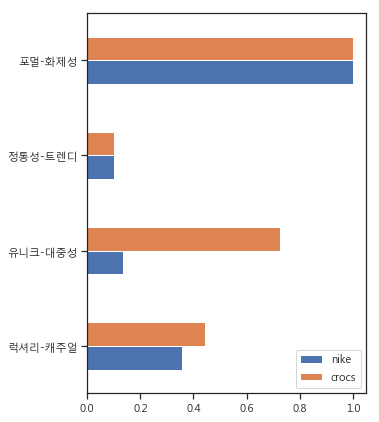

In [243]:
#df = pd.read_pickle('model/id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df_id)
df2 = df_id.copy()
df2[:] = X_train_minmax
df2[['nike','crocs']].plot.barh(figsize=(5,7))

In [245]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                    12
1017alyx9sm             12
8seconds                 2
99percentis              1
aape                    14
abecrombiefitch         11
acnestudios              9
acoldwall               13
acronym                 12
adererror                6
adidas                  12
adidasoriginal           0
aecawhite                6
aimeleondore            18
aldo                     6
alexandermcqueen        10
alexanderwang            0
allsaints                7
alphaindustry            7
ambush                   1
ami                      7
amiri                    2
antisocialsocialclub     1
apc                      6
arcteryx                15
asics                   18
awakeny                 10
balenciaga               0
bally                    3
balmain                 10
                        ..
tomsshoes                6
topshop                 18
topten                   2
toryburch               17
tumi                    10
ugg                      0
u

In [247]:
clrd = pd.DataFrame(clustered.sort_values()).reset_index()
clrd.columns = ['bname', 'cluster']
clrd.to_excel('model/clustered.xlsx')

In [250]:
clrd[clrd.bname=='chanel']

,bname,cluster
158,chanel,10


In [251]:
clustered.index[clustered==10]

Index(['alexandermcqueen', 'awakeny', 'balmain', 'bottegaveneta', 'burberry',
       'chanel', 'dior', 'dkny', 'ermenegildozegna', 'fendi', 'ferragamo',
       'gentlemonster', 'gucci', 'hermes', 'heronpreston', 'lanvin',
       'louisvuitton', 'n21', 'prada', 'tods', 'tumi', 'versace'],
      dtype='object')

In [323]:
df2.loc['신뢰성']

032c                    0.921131
1017alyx9sm             1.000000
8seconds                0.894010
99percentis             0.773222
aape                    0.975499
abecrombiefitch         0.844910
acnestudios             1.000000
acoldwall               1.000000
acronym                 1.000000
adererror               1.000000
adidas                  0.907210
adidasoriginal          1.000000
aecawhite               1.000000
aimeleondore            0.809190
aldo                    1.000000
alexandermcqueen        1.000000
alexanderwang           1.000000
allsaints               1.000000
alphaindustry           0.916350
ambush                  0.815106
ami                     0.947703
amiri                   0.979774
antisocialsocialclub    0.971174
apc                     0.955957
arcteryx                0.983103
asics                   0.862977
awakeny                 0.987181
balenciaga              1.000000
bally                   0.899009
balmain                 0.930140
          